In [33]:
%load_ext autoreload
%autoreload 2

In [12]:
import pandas as pd

In [7]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [29]:
import os
os.chdir("/content/drive/MyDrive/ml-for-healthcare")

#### Implement an LSTM network, train it on the PTB dataset, and report test set performance (2 pts)

Load data

In [30]:
train = pd.read_csv("ptbdb_train.csv", header=None)
test = pd.read_csv("ptbdb_test.csv", header=None)

In [17]:
train.shape, test.shape

((11641, 188), (2911, 188))

<Axes: >

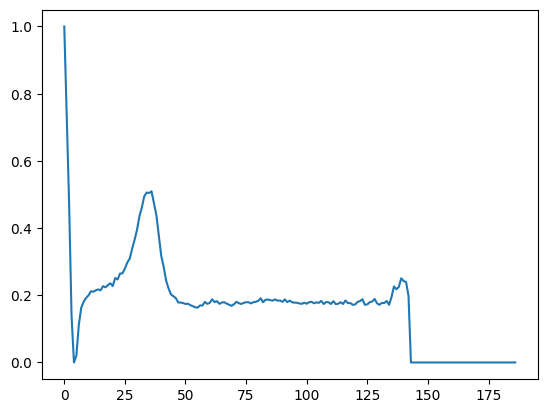

In [18]:
train.iloc[0, 0:-1].plot()

Prepare data

In [91]:
X_train = train.iloc[:,0:-1]
y_train = train.iloc[:,-1]

X_test = test.iloc[:,0:-1]
y_test = test.iloc[:,-1]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((11641, 187), (11641,), (2911, 187), (2911,))

Construct RNN

In [24]:
BATCH_SIZE = 16

In [92]:
# train val split
from sklearn.model_selection import train_test_split
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [96]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# prepare train data
train_train_dataset = TensorDataset(torch.tensor(X_train_train.to_numpy()).float(), torch.tensor(y_train_train.to_numpy()).float())
train_train_loader = DataLoader(train_train_dataset, shuffle=True, batch_size=BATCH_SIZE)

# validation data
X_val_dataset = torch.tensor(X_train_val.to_numpy()).float()

In [97]:
t = next(iter(train_train_loader))
t[0].shape, t[1].shape

(torch.Size([16, 187]), torch.Size([16]))

In [54]:
t[1].unsqueeze(1).shape

torch.Size([16, 1])

In [86]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


Training with validation set

In [87]:
from rnn import TimeSeriesClassifierRNN, train_rnn
from sklearn.metrics import f1_score

model = TimeSeriesClassifierRNN(
    input_size=187,
    output_size=1,
    hidden_size=32,
    num_layers=1
).to(device)

train_rnn(
    model=model,
    epochs=15,
    batch_size=BATCH_SIZE,
    train_loader=train_train_loader,
    X_val=X_val_dataset,
    y_val=y_train_val,
    val_score=f1_score,
    device=device
)

epoch: 0, train loss: 0.4364164887439637, validation score: 0.8663282571912014
epoch: 1, train loss: 0.35750303279785883, validation score: 0.8814675446848542
epoch: 2, train loss: 0.3103978567534969, validation score: 0.9010884997633697
epoch: 3, train loss: 0.2696665416161219, validation score: 0.9111747851002865
epoch: 4, train loss: 0.2427459358601343, validation score: 0.924187725631769
epoch: 5, train loss: 0.2197012746937218, validation score: 0.9168190127970749
epoch: 6, train loss: 0.19751138002389954, validation score: 0.9354389224338132
epoch: 7, train loss: 0.19083905642940885, validation score: 0.9367789570835257
epoch: 8, train loss: 0.1757648613596601, validation score: 0.9383301707779885
epoch: 9, train loss: 0.16466208988179762, validation score: 0.943378568086102
epoch: 10, train loss: 0.1586046676568332, validation score: 0.9408553230209281
epoch: 11, train loss: 0.14895016733202196, validation score: 0.948529411764706
epoch: 12, train loss: 0.1435548629460945, valid

Training on full dataset

In [106]:
# prepare train data
train_dataset = TensorDataset(torch.tensor(X_train.to_numpy()).float(), torch.tensor(y_train.to_numpy()).float())
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)

# prepare test data
X_test_dataset = torch.tensor(X_test.to_numpy()).float()

In [100]:
from rnn import TimeSeriesClassifierRNN, train_rnn
from sklearn.metrics import f1_score

model = TimeSeriesClassifierRNN(
    input_size=187,
    output_size=1,
    hidden_size=32,
    num_layers=1
).to(device)

train_rnn(
    model=model,
    epochs=15,
    batch_size=BATCH_SIZE,
    train_loader=train_loader,
    device=device
)

epoch: 0, train loss: 0.40593235448843185, validation score: not evaluated
epoch: 1, train loss: 0.3192891424170796, validation score: not evaluated
epoch: 2, train loss: 0.26691097706720296, validation score: not evaluated
epoch: 3, train loss: 0.23493288028242254, validation score: not evaluated
epoch: 4, train loss: 0.2133819260768992, validation score: not evaluated
epoch: 5, train loss: 0.19401914428053565, validation score: not evaluated
epoch: 6, train loss: 0.17480681477398952, validation score: not evaluated
epoch: 7, train loss: 0.16006156676506528, validation score: not evaluated
epoch: 8, train loss: 0.1611751089579691, validation score: not evaluated
epoch: 9, train loss: 0.1482997489593503, validation score: not evaluated
epoch: 10, train loss: 0.13932527221119265, validation score: not evaluated
epoch: 11, train loss: 0.12859584106884364, validation score: not evaluated
epoch: 12, train loss: 0.12346035793412123, validation score: not evaluated
epoch: 13, train loss: 0.1

Performance on test set

In [110]:
model.eval()
with torch.no_grad():
  X_test = X_test_dataset.to(device)
  y_pred, _ = model(X_test)

In [115]:
f1_score(y_pred.squeeze(1).detach().numpy().round(), y_test)

0.9589622641509434